# Assignment 3 ISPR (Signals) ~ Paul M. Magos 588669
In Python you can import WAVs (and acces several other music-related functions), using the LibROSA library.

### Import libraries & samples

In [1]:
from os import walk
#  Import library for wav ( actually this lib is mp3s )
import librosa as lrosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy


def getSamples(name):
    saplesDir = "./samples/"
    tmpDir = saplesDir + name
    # Take each file in the directory
    # Add all of them in a list and append to each name the directory path
    tmp = [tmpDir + s for s in next(walk(tmpDir), (None, None, []))[2]] 
    return tmp
    
def getNote(mylist, spec=['Fs4', 'forte', 'normal']):
    return [s for s in mylist if all(ext in s for ext in spec)].pop()

### Function to trim the audio file (delete the quiet spaces), calculate the Fourier Transform, the Spectral Centroid and the RMS (power).

In [3]:
def calculate(y):
    # Trim the silence
    y = librosa.effects.trim(y)[0]
    
    # Calulate Spectral Centroid and RMS (Power)
    S = lrosa.magphase((lrosa.stft(y)))[0]
    Centroid = lrosa.feature.spectral_centroid(S=S)
    rms = lrosa.feature.rms(S=S)
    times = lrosa.times_like(Centroid)
    
    return y, S, Centroid, rms, times


### Function to plot the various plots
    1. Top_Left: Linear Spectrogram
    2. Top_Right: Logaritmic Spectogram with spectral centroid
    3. Bottom_Left: Wavelet
    4. Bottom_Right: Rms power lineplot

In [4]:
def plotGrid(y, sr, title, cmap='plasma'):
    # Define plt dimension
    fig = plt.figure(figsize=(21, 9))
    fig.suptitle(title)
    
    y, S, Centroid, rms, times = calculate(y)
    
    # Divide it in the 3 plots
    gs = GridSpec(10,2, figure=fig)
    ax00 = fig.add_subplot(gs[0:6,0])
    ax01 = fig.add_subplot(gs[0:6,1])
    ax10 = fig.add_subplot(gs[-3,0])
    ax11 = fig.add_subplot(gs[-3,1])
    
    # Apply the Fourier Transform (DFT) to the data and get absolute values (Librosa documentation)
    D = lrosa.amplitude_to_db(np.abs(lrosa.stft(y)), ref=np.max)
    
    # Display a spectogram of the DFT of the instrument note in linear scale 
    img = lrosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax00, cmap=cmap)
    ax00.set(title='Linear-frequency power spectrogram')
    fig.colorbar(img, ax=ax00, format="%+2.1f dB")
    
    # Display a spectogram of the DFT of the instrument note in logaritmic scale 
    img2 = lrosa.display.specshow(lrosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', ax=ax01, cmap="viridis")
    ax01.plot(times, Centroid.T, label='Spectral centroid', color='w')
    ax01.legend(loc='upper right')
    ax01.set(title='Log-frequency power spectrogram')
    fig.colorbar(img2, ax=ax01, format="%+2.1f dB")
    
    # Wave
    ax10.set(title='Wave')
    lrosa.display.waveshow(y, sr=sr, ax=ax10)
    
    ax11.semilogy(times, rms[0],label='RMS Energy')
    ax11.legend()
    ax11.set_xlabel('Time')
    ax11.set(title='RMS Energy')

# 1. Let's plot the Spectrograms

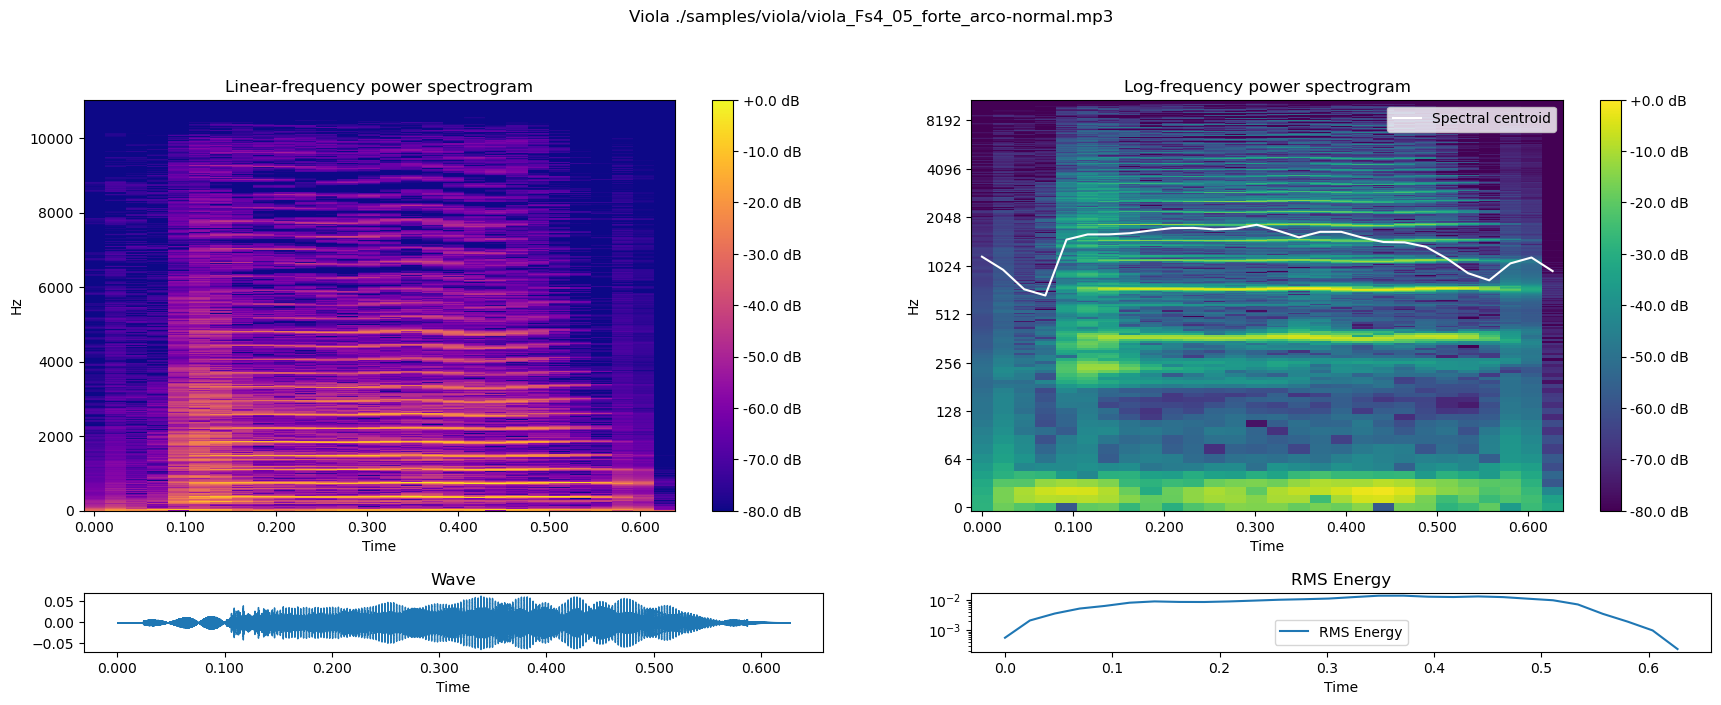

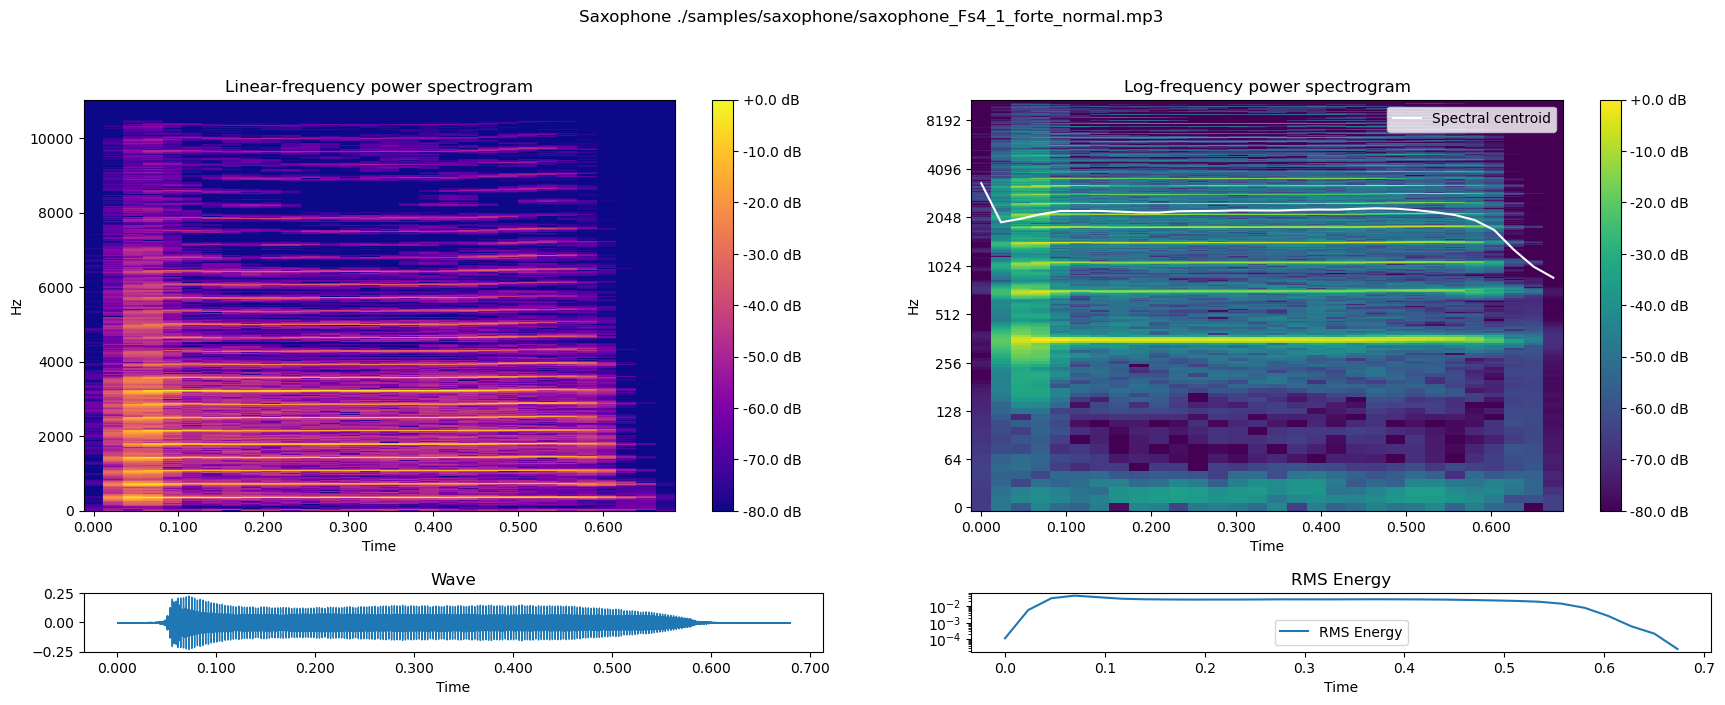

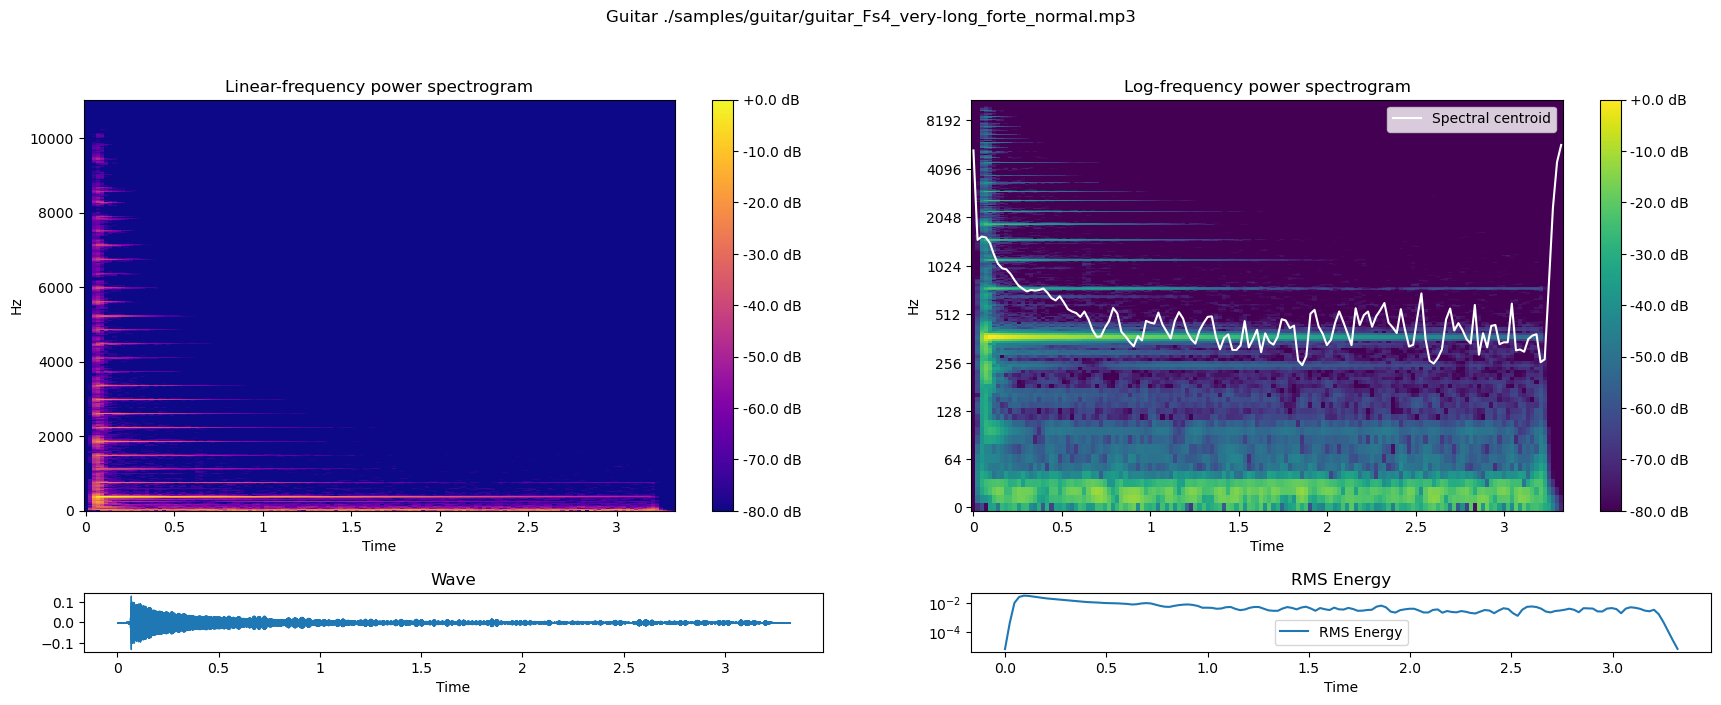

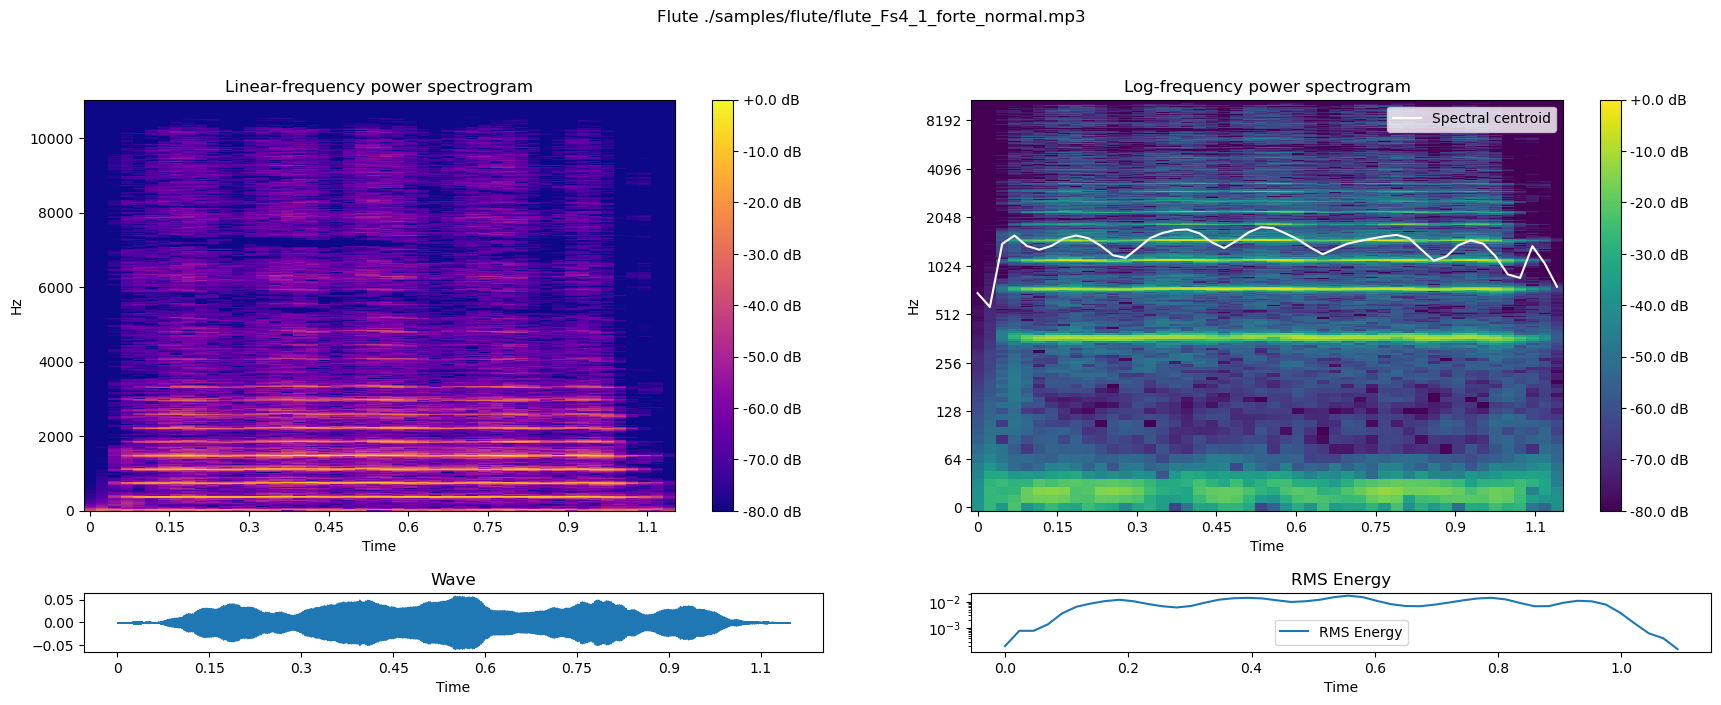

In [2]:
violaDataset = getSamples("viola/")
saxDataset = getSamples("saxophone/")
guitarDataset = getSamples("guitar/")
fluteDataset = getSamples("flute/")

violaNotePath = getNote(violaDataset)
saxNotePath = getNote(saxDataset)
guitarNotePath = getNote(guitarDataset)
fluteNotePath = getNote(fluteDataset)

viola, violasr = lrosa.load(violaNotePath)
sax, saxsr = lrosa.load(saxNotePath)
guitar, guitarsr = lrosa.load(guitarNotePath)
flute, flutesr = lrosa.load(fluteNotePath)

plotGrid(viola, violasr, "Viola " + violaNotePath)
plotGrid(sax, saxsr, "Saxophone " + saxNotePath)
plotGrid(guitar, guitarsr, "Guitar " + guitarNotePath)
plotGrid(flute, flutesr, "Flute " + fluteNotePath)

### 2. Let's make some discussion on the spectorgrams after the Short-time Fourier transform (STFT).

* Instruments:
    1. Viola
    2. Saxophone
    3. Guitar
    4. Flute 
* We used the stft method of the librosa library to transform out audio files in a fourier series. The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows. (Librosa documentation)
* For each instrument we used the same note (Fs4), with the same intensity (forte), and no variations (normal).
 
#### We can clearly distinguish the instrument between them by their waveform (left-bottom) even if we choose the same note for each of them since they have different forms and intensity. This doesn't mean that we can say which is which.


* On the linear spectogram (left-top) side instead it's a little bit different:
    1. We have some similar result for Saxophone and Flute in linear scale. 
    2. The Viola it's similar to the previous cited ones with a little bit of difference, we have really fast frequency shift (probably due to the fact that we have a bow that makes the sound more continuos). 
    3. The only one different from the other would be the Guitar, but if we pay attention it's actually similar to the others in the shape of lines that we can see. We can see in the waveplot that have more attack at the beginning and a release that's more fast than the other instruments.

* The log spectogram (right-top), as well as the spectral centroid are more interesting since we can clearly see which is the most interesting frequency for each instrument. 
    1. The Viola and the Saxophone as well as the Flute, have a spectral centroid that converge arount the 1024-2038 Hz. 
    2. The Flute differently from the others have a repeated pattern in the sound, we can see that it repeats almost all the frequency that it has every 0.15s - 0.20s.
    3. The Guitar is the more different one, probably because of the things that we described before, but it's more stationary around 512 Hz, differently from the other instruments.

# Conclusions

### We can say that probably only by using the spectrogram we can't really recognise the instruments.

### Improvements
* Try to load all the notes from all the instruments and then try to use some classification techniques like timeseries analysis with NN ([Rocket](https://doi.org/10.1145/3447548.3467231) has good results with timeseries in a small amount of time) to better understand which instruments could be the more similar/different. This example could let to being able to find some instruments that are distinguishable by only looking at spectrograms.
* Maybe a clustering algorithm could be used too to make some tests over the kind of instruments like wind, stringed, percussion instruments and so on. Verifying if a clustering algorithm could find differences between instruments. 

#### Links
* [GitHub](https://github.com/PaulMagos/ISPR/blob/main/Assigment1/Assigment1.ipynb)